# Project Overview:

**Goal:** Build an encoder-decoder LSTM model to predict stock prices 30 days ahead using historical data.
**Required Libraries:**

    - Pandas , NumPy, Matplotlib, Seaborn
    - TensorFlow, Keras, Scikit-Learn
    - yFinance, ta-lib

**Dataset Choice: Yahoo Finance API via yfinance**
Why this dataset?

    - Free & accessible
    - Real-world stock data with actual issues (missing values, weekends/holdiays gaps, stock splits)
    - Forces you to handle non-stationarity, noise, and data irregularities
    - Contains OHLCV data needed for technical indicators

First, we're going to collect data. We're going to download 10 years worth of data for multiple stocks, generally the ones in FAANG (AAPL, MSFT, GOOGL, AMZN, TSLA), however for training we're going to focus on one stock initially

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)

data = {}
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end= end_date, interval='1d')
    data[ticker] = df
    df.to_csv(f'data/raw_{ticker}.csv')


/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_80952/1737058979.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end= end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed
/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_80952/1737058979.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end= end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed
/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_80952/1737058979.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end= end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed
/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_80952/1737058979.py:11: Fu

We're going to initially focus on the APPL stock

In [8]:
apple_data = data['AAPL']
apple_data.to_csv('data/raw_AAPL.csv')

Now, we move on to data cleaning and exploration

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Initial inspection

In [24]:
apple_data = pd.read_csv('data/raw_AAPL.csv', skiprows=[1,2], index_col=0, parse_dates=True)
apple_data.index.name = 'Date'
# Flatten the multi-level columns if they exist
if isinstance(apple_data.columns, pd.MultiIndex):
    apple_data.columns = apple_data.columns.get_level_values(0)

print("First 5 rows of the dataset:")
print(apple_data.head())
print("---------------------")
print("Data Info:")
print(apple_data.info())
print("---------------------")
print("Statistical Summary:")
print(apple_data.describe())
print("---------------------")
print(f"\nMissing Values:\n{apple_data.isnull().sum()}")
print("---------------------")
print(f"\nData shape: {apple_data.shape}")
print("---------------------")
print(f"\nDate range:\nFrom {apple_data.index.min()} to {apple_data.index.max()}")

First 5 rows of the dataset:
                Close       High        Low       Open     Volume
Date                                                             
2015-11-27  26.562487  26.697769  26.515138  26.670712   52185600
2015-11-30  26.672972  26.923242  26.548963  26.603075  156721200
2015-12-01  26.456522  26.787962  26.348298  26.774434  139409600
2015-12-02  26.217531  26.630140  26.172438  26.456528  133546400
2015-12-03  25.974022  26.332518  25.753063  26.278406  166278000
---------------------
Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2512 entries, 2015-11-27 to 2025-11-21
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2512 non-null   float64
 1   High    2512 non-null   float64
 2   Low     2512 non-null   float64
 3   Open    2512 non-null   float64
 4   Volume  2512 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.8 KB
None
---------------------
Statistical Su

Checking for missing values to carry on Data cleaning and exploration

In [25]:
print(apple_data.isnull().sum())
apple_data.head()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


,Close,High,Low,Open,Volume
Date,,,,,
2015-11-27,26.562487,26.697769,26.515138,26.670712,52185600
2015-11-30,26.672972,26.923242,26.548963,26.603075,156721200
2015-12-01,26.456522,26.787962,26.348298,26.774434,139409600
2015-12-02,26.217531,26.630140,26.172438,26.456528,133546400
2015-12-03,25.974022,26.332518,25.753063,26.278406,166278000


let's check for outliers now, generally outliers can distort model training, but in stocks, some of these are real events (earnings, splits), therefore we're going to check for extreme outliers in Volume, flag them and do some visualizations

Volume outliers found: 31


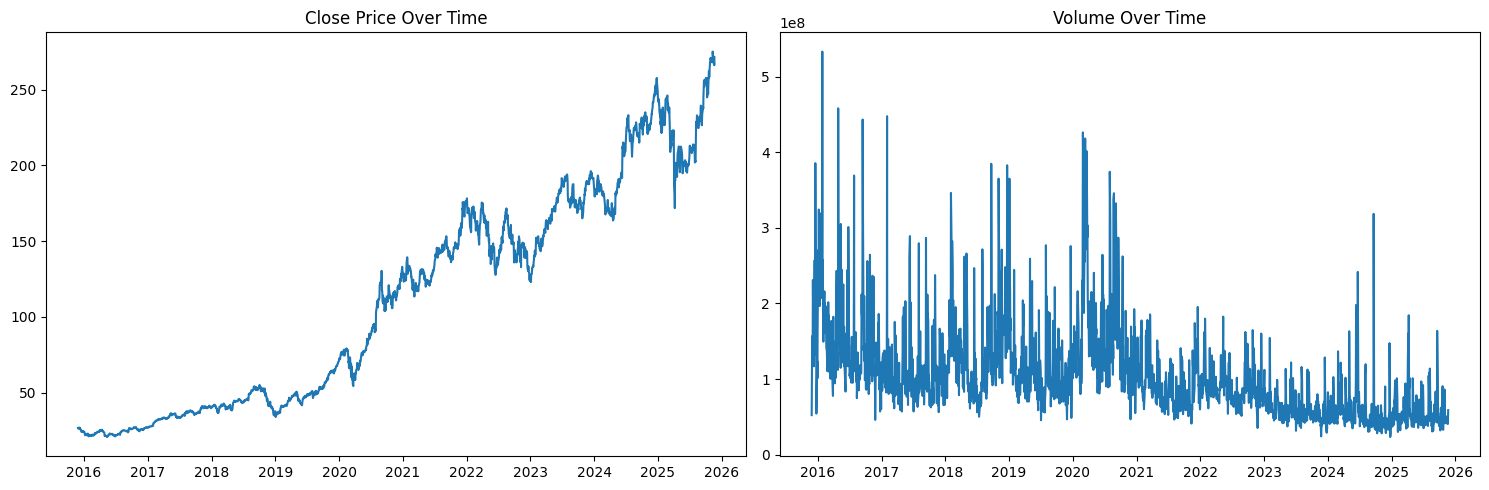

In [28]:
Q1 = apple_data['Volume'].quantile(0.25)
Q3 = apple_data['Volume'].quantile(0.75)
IQR = Q3 - Q1

# flagging outliers, stock splits can cause legitimate spikes in volume
volume_outliers = apple_data[(apple_data['Volume'] < (Q1 - 3 * IQR)) | (apple_data['Volume'] > (Q3 + 3 * IQR))]
print(f"Volume outliers found: {len(volume_outliers)}")

# visualizing to determine if removals are needed
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(apple_data['Close'])
plt.title('Close Price Over Time')
plt.subplot(1,2,2)
plt.plot(apple_data['Volume'])
plt.title('Volume Over Time')
plt.tight_layout()
plt.savefig('plots/01_raw_data_visualiszation.png')
plt.show()

now, let's check for duplicate dates

In [30]:
duplicates = apple_data.index.duplicated().sum()
print(f"Duplicate dates: {duplicates}")

Duplicate dates: 0
